<a href="https://colab.research.google.com/github/LabSWPP12023S2G2/TPInicial/blob/main/kmeansbetternewnew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.spatial import ConvexHull
from scipy.spatial import QhullError


# Carga de dataset
url = 'https://raw.githubusercontent.com/LabSWPP12023S2G2/TPInicial/main/datasetUNC.csv'
data = pd.read_csv(url, delimiter=';')
columns_to_drop = ['SUB PERIODS', 'SEX']
data = data.drop(columns=columns_to_drop)
data = data.dropna(axis=0)
data.drop(data[data['PROVINCE'] == 'Otro'].index, inplace=True)
data.drop(data[data['PROVINCE'] == 'other'].index, inplace=True)

# Asignaciones para columnas no númericas
assignment_mapping = {
    'MENTAL DISORDER HISTORY': {'no': 0, 'yes': 50},
    'EDUCATION': {
        'Completed postgraduate': 30,
        'Incomplete tertiary or university': 60,
        'Completed high school': 70,
        'Incomplete postgraduate': 40,
        'Completed tertiary or university': 50,
        'Incomplete high school': 80,
        'Incomplete elementary school': 100,
        'Completed elementary school': 90,
        'Otro': 50
    },
    'SUIC ATTEMPT HISTORY': {'ideation': 50, 'no': 0, 'yes': 100},
    'LIVING WITH SOMEBODY': {'no': 20, 'yes': 0},
    'ECONOMIC INCOME': {'yes': 0, 'no': 50}
}

# Aplicamos las asignaciones
for column, mapping in assignment_mapping.items():
    data[column] = data[column].map(mapping)

#ocurrences = data['PROVINCE'].value_counts()
#print(ocurrences)

# Función para asignar una región a cada provincia
def assign_region(province):
    if province in ['Corrientes', 'Chaco', 'Misiones', 'Formosa', 'Entre Ríos']:
        return 'Nordeste-Litoral'
    elif province in ['Tucumán', 'Jujuy', 'Salta', 'Catamarca', 'Santiago del Estero']:
        return 'Noroeste'
    elif province in ['San Luis', 'San Juan', 'Mendoza', 'La Rioja']:
        return 'Cuyo'
    elif province in ['Neuquén', 'Río Negro', 'La Pampa']:
        return 'Patagonia Centro-Norte'
    elif province in ['Tierra del Fuego', 'Santa Cruz', 'Chubut']:
        return 'Patagonia Centro-Sur'
    elif province == 'Santa Fe':
        return 'Santa Fe'
    elif province == 'Buenos Aires provincia':
        return 'Buenos Aires'
    elif province == 'Córdoba':
        return 'Córdoba'
    else:
        return 'CABA'

# Aplicamos la función a la columna 'PROVINCE' y guardamos el resultado en una nueva columna 'REGION'
data['REGION'] = data['PROVINCE'].apply(assign_region)

# Crea un LabelEncoder para codificar la columna 'REGION'
#label_encoder = LabelEncoder()
#data['REGION_ENCODED'] = label_encoder.fit_transform(data['REGION'])

# Seleccionamos las columnas relevantes para el clustering
#data_ref = data.groupby('PROVINCE').mean()

In [43]:
columns_to_drop = ['REGION', 'PROVINCE', 'SUIC RISK']
data_ref = data.drop(columns=columns_to_drop)
data_ref

,EDUCATION,AGE,MENTAL DISORDER HISTORY,SUIC ATTEMPT HISTORY,LIVING WITH SOMEBODY,ECONOMIC INCOME,DEPRESSION,ANXIETY STATE,ANXIETY TRAIT
0,30,30,0,50,20,0,21,54,40
1,60,30,0,50,0,0,26,34,36
2,70,39,50,0,20,0,8,33,29
3,60,36,0,0,0,50,27,42,48
5,30,35,0,0,0,0,9,25,12
...,...,...,...,...,...,...,...,...,...
1095,30,28,0,100,0,0,41,51,47
1096,50,39,0,0,0,0,10,31,25
1097,60,22,0,0,0,0,7,27,24
1098,40,31,0,0,0,0,6,14,20


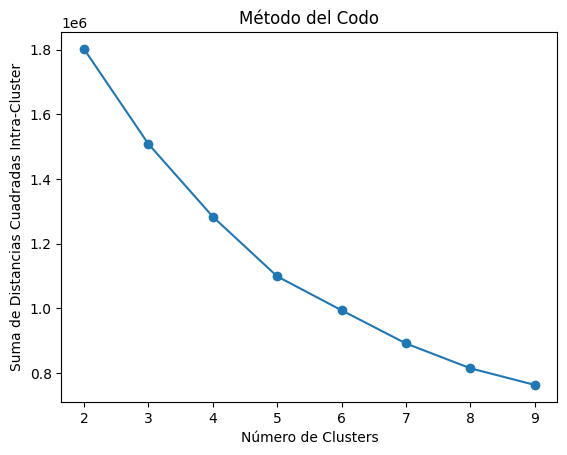

In [35]:
'''
n_clusters: En el paso de aplicar K-Means calcularemos
la cantidad de clusters con el Método del codo
'''
inertia_values = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=0)
    kmeans.fit(data_ref)
    inertia_values.append(kmeans.inertia_)

# Grafica la suma de las distancias cuadradas intra-cluster en función de k
plt.plot(range(2, 10), inertia_values, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Suma de Distancias Cuadradas Intra-Cluster')
plt.title('Método del Codo')
plt.show()

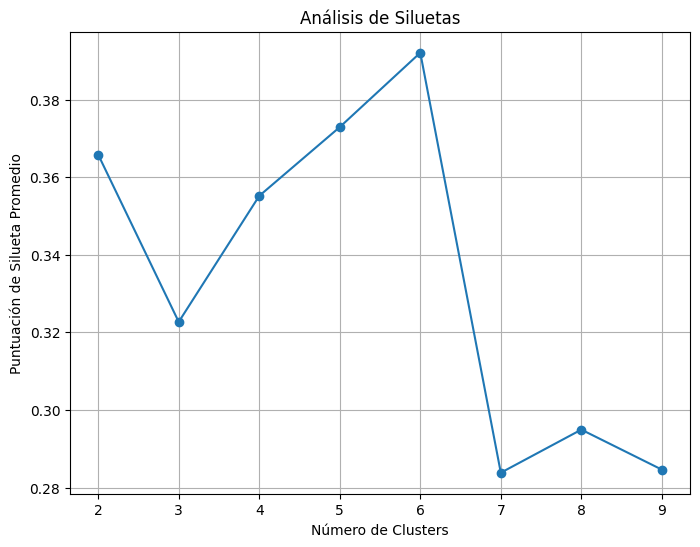

In [18]:
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=0)
    cluster_labels = kmeans.fit_predict(data_ref)

    silhouette_avg = silhouette_score(data_ref, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    # Calcular las puntuaciones de silueta para cada muestra
    sample_silhouette_values = silhouette_samples(data_ref, cluster_labels)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Puntuación de Silueta Promedio')
plt.title('Análisis de Siluetas')
plt.grid(True)
plt.show()

In [44]:
# Aplicamos K-Means para clasificar las regiones en grupos
kmeans = KMeans(n_clusters=6, n_init=100, random_state=0).fit(data_ref)

# Asigna un color a cada región en base a los clusters
data_ref['Cluster'] = kmeans.labels_

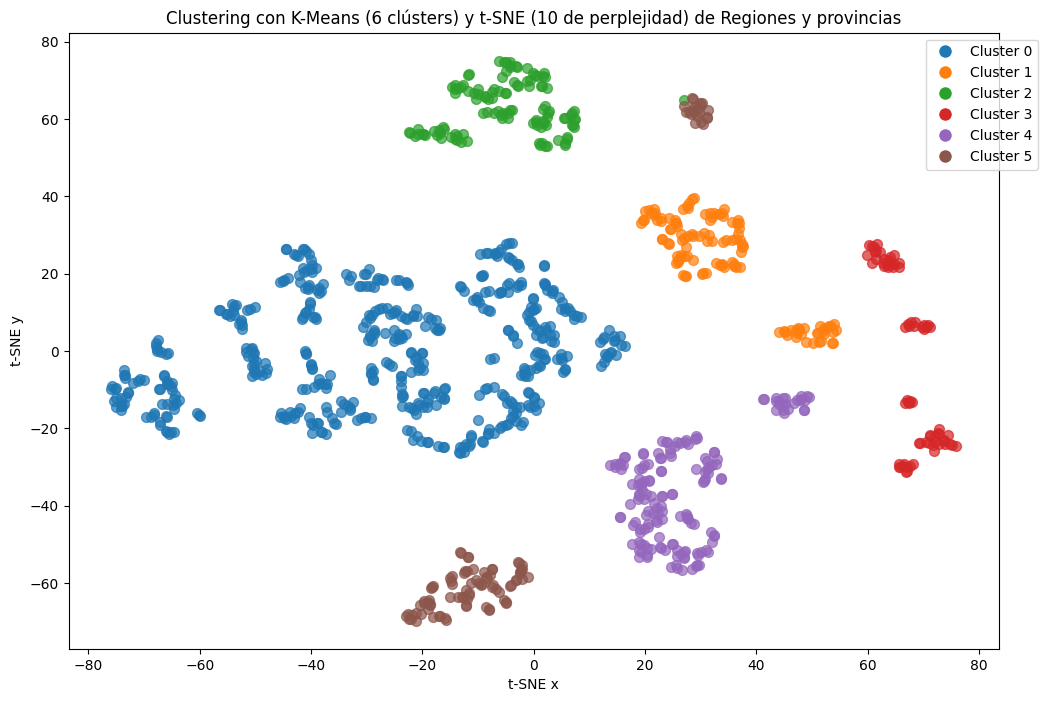

In [45]:
# Reducción de dimensionalidad con t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=10)
tsne_coordinates = tsne.fit_transform(data_ref)
data_ref['tsne_x'] = tsne_coordinates[:, 0]
data_ref['tsne_y'] = tsne_coordinates[:, 1]

# Generación de colores para los clusters
cluster_colors = plt.cm.tab10.colors
plt.figure(figsize=(12, 8))
unique_clusters = np.unique(kmeans.labels_)
data_ref['PROVINCE'] = data['PROVINCE']
for cluster in unique_clusters:
    cluster_data = data_ref[data_ref['Cluster'] == cluster]
    plt.scatter(cluster_data['tsne_x'], cluster_data['tsne_y'],
                label=f'Cluster {cluster}', alpha=0.7, s=50)

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=f'C{cluster}', markersize=10, label=f'Cluster {cluster}') for cluster in unique_clusters]

# Coloca la leyenda al costado del gráfico
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.05, 1))

plt.title('Clustering con K-Means (6 clústers) y t-SNE (10 de perplejidad) de Regiones y provincias')
plt.xlabel('t-SNE x')
plt.ylabel('t-SNE y')
plt.show()

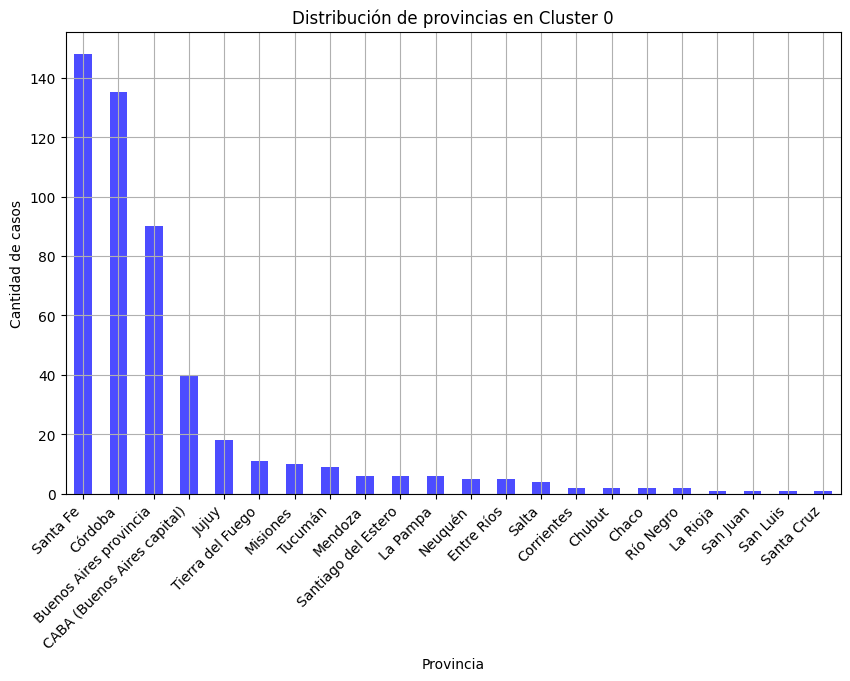

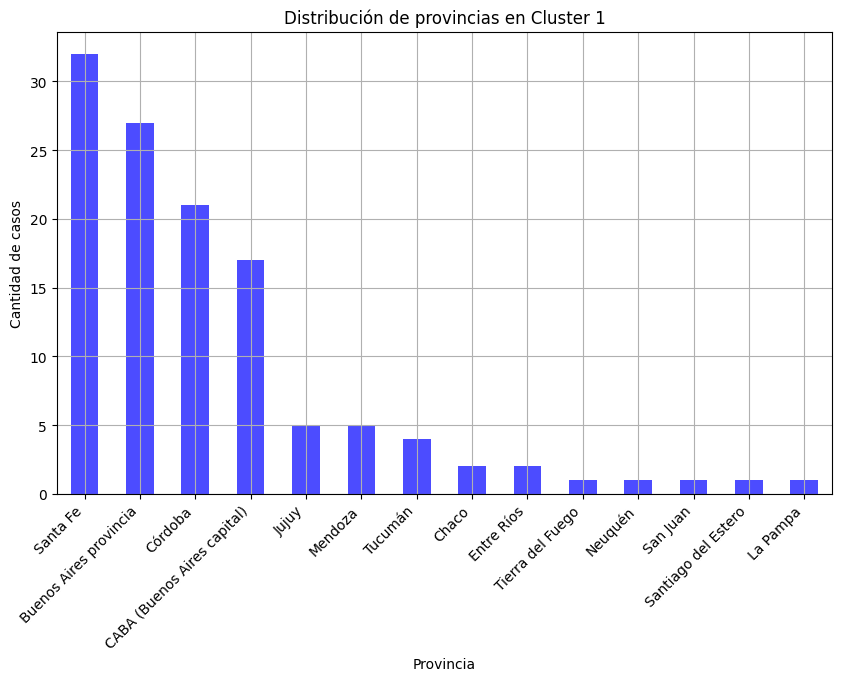

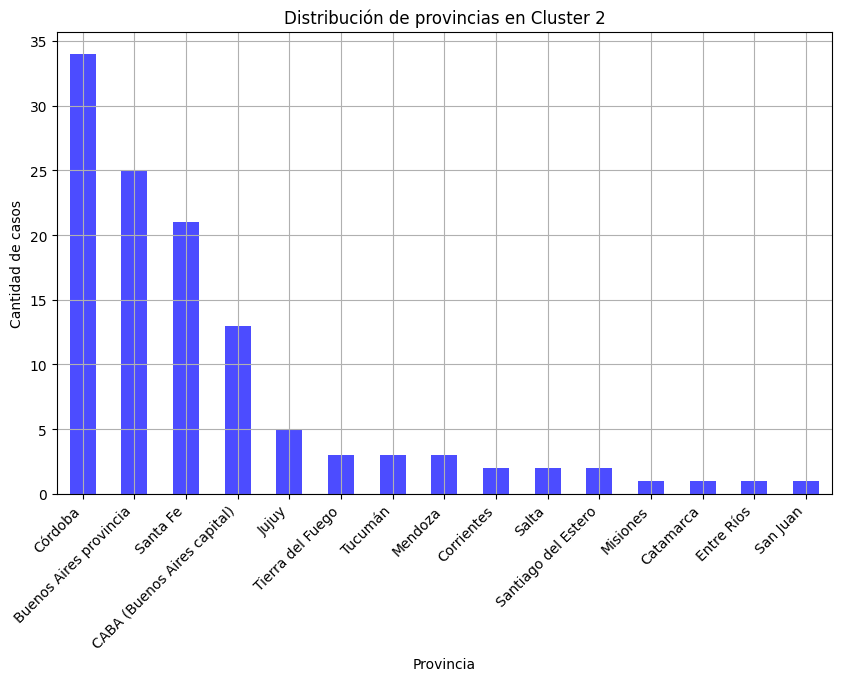

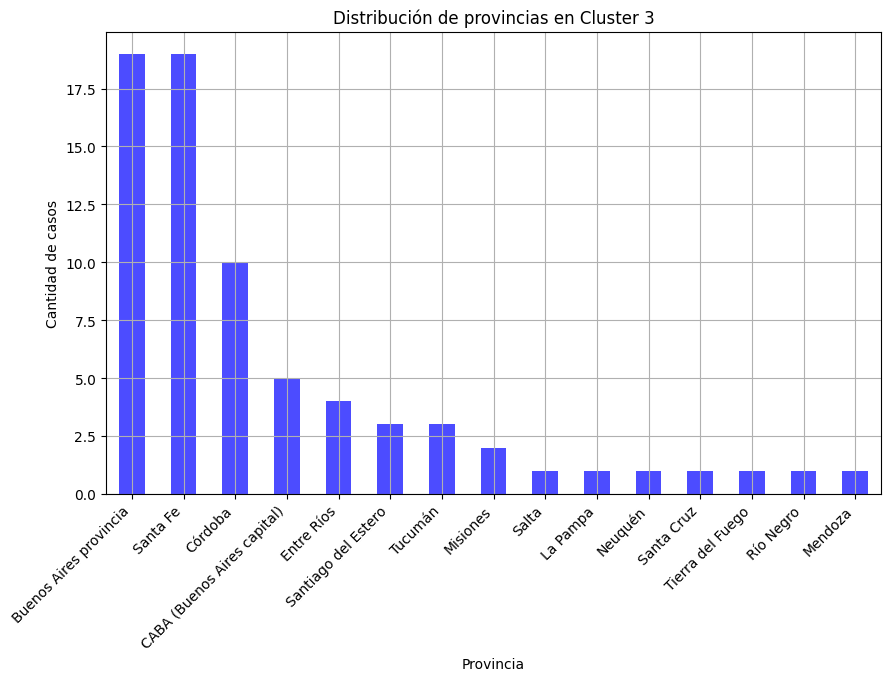

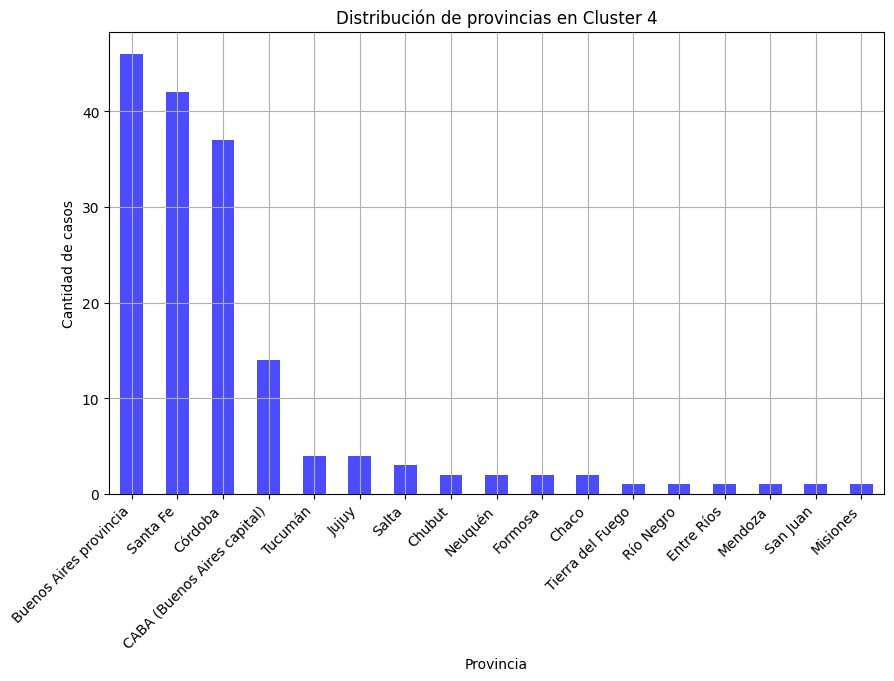

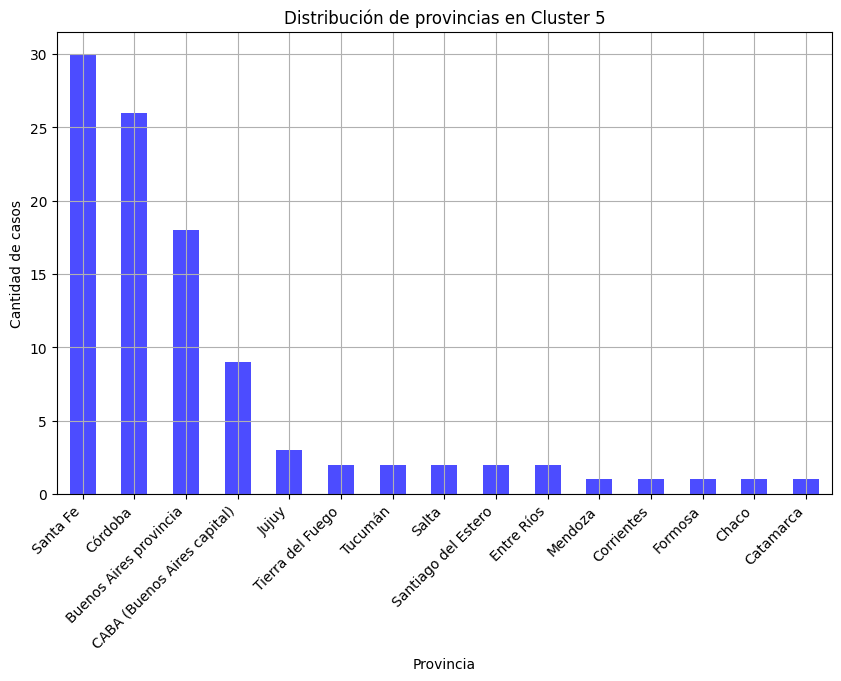

In [46]:
# Crea un gráfico de distribución de provincias para cada cluster
unique_clusters = np.unique(kmeans.labels_)
for cluster in unique_clusters:
    cluster_data = data_ref[data_ref['Cluster'] == cluster]
    province_counts = cluster_data['PROVINCE'].value_counts()

    plt.figure(figsize=(10, 6))
    province_counts.plot(kind='bar', color='blue', alpha=0.7)

    plt.title(f'Distribución de provincias en Cluster {cluster}')
    plt.xlabel('Provincia')
    plt.ylabel('Cantidad de casos')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)

    plt.show()